# Import, Init

In [12]:
import tensorflow as tf 

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print('Error')
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [13]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [14]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

NULLS in data -->  7
>>> train-test inited:  
 	X_train len -->  1598 y_train len -->  1598 
 	X_test len -->  2395 y_test len -->  2395 
 	NULLS in data -->  7


In [16]:
# loaded

nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY',
       'PRICE_UP'],
      dtype='object')

In [17]:
# nn_manager_cut.X_test.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
#                            inplace=True, errors='ignore')
# nn_manager_cut.X_train.drop(columns=['VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY', 'Open'], 
#                             inplace=True, errors='ignore')

## SR: MWNUS_CH_PDAY is not refreshed in the source DS => supplies nulls for last week
nn_manager_cut.X_test.drop(columns=[ 'MWNUS_CH_PDAY', 'Open'], inplace=True, errors='ignore')
nn_manager_cut.X_train.drop(columns=[ 'MWNUS_CH_PDAY', 'Open'], inplace=True, errors='ignore')

nn_manager_cut.X_train.columns

Index(['High', 'Low', 'Vol', 'TOUTV', 'TRFEE', 'AVBLS', 'NTRAT',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'NTRAT_CH_PDAY', 'PRICE_UP'],
      dtype='object')

In [18]:
nn_manager_cut.count_nulls_in_data()

NULLS in data -->  0


# Preparing data

#### Swapping (the trial issue)
[[to #Model-fit]](#Model-fit)

In [7]:
tmp = nn_manager_cut.X_test.copy()
nn_manager_cut.X_test = nn_manager_cut.X_train.copy()
nn_manager_cut.X_train = tmp.copy()

tmp = nn_manager_cut.y_test.copy()
nn_manager_cut.y_test = nn_manager_cut.y_train.copy()
nn_manager_cut.y_train = tmp.copy()

print("X_train => ", nn_manager_cut.X_train.shape[0])
print("X_test => ", nn_manager_cut.X_test.shape[0])
print("\ttrain data period => ", nn_manager_cut.X_train.index.min(), "-->", nn_manager_cut.X_train.index.max())
print("\ttest data period => ", nn_manager_cut.X_test.index.min(), "-->", nn_manager_cut.X_test.index.max())

X_train =>  2395
X_test =>  1598
	train data period =>  2014-12-02 00:00:00 --> 2021-06-22 00:00:00
	test data period =>  2010-07-18 00:00:00 --> 2014-12-01 00:00:00


#### Keeping Left-off Samples Aside

In [8]:
left_off_days = 21
left_off_X = nn_manager_cut.X_train[-left_off_days:].copy()
nn_manager_cut.X_train = nn_manager_cut.X_train[:-left_off_days]

left_off_y = nn_manager_cut.y_train[-left_off_days:].copy()
nn_manager_cut.y_train = nn_manager_cut.y_train[:-left_off_days]

nn_manager_cut.X_train.shape[0], nn_manager_cut.X_test.shape[0]

(2374, 1598)

## Normalizing

In [9]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer

nn_manager_cut.normalize_X(scaler=RobustScaler)
# nn_manager_cut.transform_X(transformer=QuantileTransformer)

(
    nn_manager_cut.X_test_normalized[:2], 
    nn_manager_cut.X_test_transformed
)

(array([[-0.59074168, -0.5763796 , -0.31187386, -1.26079986, -0.55951804,
         -2.50048655, -0.9379086 ,  8.95800933,  0.04630092, -1.32275738,
         -1.        ],
        [-0.59074168, -0.5763796 , -0.31066995, -1.2664438 , -0.56323861,
         -2.50009536, -0.93790665,  8.95800933,  0.04630092, -1.32275738,
         -1.        ]]),
 None)

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

#### Setting sequence len

In [10]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=6))

self.training_seq_params -->  {'seq_len': 6, 'n_features': 11}
self.X_train_shape -->  [6, 11]
self.X_test_shape -->  [6, 11]


True

In [11]:
nn_manager_cut.unroll_train_test_to_sequences()

True

In [12]:
nn_manager_cut.X_test_unrolled[0]

array([[-0.59074168, -0.5763796 , -0.31187386, -1.26079986, -0.55951804,
        -2.50048655, -0.9379086 ,  8.95800933,  0.04630092, -1.32275738,
        -1.        ],
       [-0.59074168, -0.5763796 , -0.31066995, -1.2664438 , -0.56323861,
        -2.50009536, -0.93790665,  8.95800933,  0.04630092, -1.32275738,
        -1.        ],
       [-0.59074168, -0.5763796 , -0.31143161, -1.26800916, -0.56323861,
        -2.50009181, -0.93790813,  4.10575428,  0.03401543, -1.32789401,
        -1.        ],
       [-0.59074168, -0.5763796 , -0.31064538, -1.26657755, -0.56323861,
        -2.50144055, -0.93790388, -4.7029549 ,  0.04369025, -1.31930192,
        -1.        ],
       [-0.59074168, -0.5763796 , -0.30676339, -1.26451234, -0.56311859,
        -2.50160692, -0.93790267, 12.34214619,  0.06303989, -1.32385177,
        -1.        ],
       [-0.59074168, -0.5763796 , -0.30617372, -1.26365096, -0.56311859,
        -2.50150037, -0.93790361, -2.83670295,  0.0424617 , -1.32709301,
        -1.   

In [13]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[1]

array([[-5.90741681e-01, -5.76379596e-01, -3.10669951e-01,
        -1.26644380e+00, -5.63238610e-01, -2.50009536e+00,
        -9.37906653e-01,  8.95800933e+00,  4.63009176e-02,
        -1.32275738e+00, -1.00000000e+00],
       [-5.90741681e-01, -5.76379596e-01, -3.11431608e-01,
        -1.26800916e+00, -5.63238610e-01, -2.50009181e+00,
        -9.37908129e-01,  4.10575428e+00,  3.40154336e-02,
        -1.32789401e+00, -1.00000000e+00],
       [-5.90741681e-01, -5.76379596e-01, -3.10645381e-01,
        -1.26657755e+00, -5.63238610e-01, -2.50144055e+00,
        -9.37903884e-01, -4.70295490e+00,  4.36902522e-02,
        -1.31930192e+00, -1.00000000e+00],
       [-5.90741681e-01, -5.76379596e-01, -3.06763389e-01,
        -1.26451234e+00, -5.63118592e-01, -2.50160692e+00,
        -9.37902668e-01,  1.23421462e+01,  6.30398894e-02,
        -1.32385177e+00, -1.00000000e+00],
       [-5.90741681e-01, -5.76379596e-01, -3.06173719e-01,
        -1.26365096e+00, -5.63118592e-01, -2.50150037e+00,
  

In [14]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(            Price
 Date             
 2010-07-18    0.1
 2010-07-19    0.1
 2010-07-20    0.1
 2010-07-21    0.1
 2010-07-22    0.1
 2010-07-23    0.1,
 array([[0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1],
        [0.1]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [15]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [16]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(6, 11)

In [17]:
# LSTM Architecture for hard periods train-test split

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    Bidirectional(
        LSTM(100, 
            activation=LeakyReLU(alpha=0.3), 
            kernel_initializer=weights_init, 
                    return_sequences=True,
            ),
        input_shape=input_model_shape,
        ),
    Bidirectional(
        LSTM(100, 
            activation=LeakyReLU(alpha=0.3), 
            kernel_initializer=weights_init, 
#                     return_sequences=True,
            ),
        ),         

#     Bidirectional(LSTM(400,                        
#                        activation=LeakyReLU(alpha=0.3), 
#                        return_sequences=True,                       
#             )),
   

#     Dense(100),
#     Dense(15),
#     Dense(100, 
#           kernel_initializer=weights_init
#          ),


#     Dense(75, 
#           kernel_initializer=weights_init
#          ),
    Dense(50, 
          kernel_initializer=weights_init
         ),
    Dense(25, 
          kernel_initializer=weights_init
         ),
    Dense(1)
]

In [18]:
nn_manager_cut.X_train_unrolled.shape

(2368, 6, 11)

### Compiling Model with the chosen Architecture

In [19]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=3e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

compile_dict = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=compile_dict)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 200)            89600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 50)                10050     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 341,751
Trainable params: 341,751
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [20]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([2368, 6, 11], [1592, 6, 11])

CPU times: user 1min 45s, sys: 6.93 s, total: 1min 52s
Wall time: 1min 8s


(0.0, 2000.0)

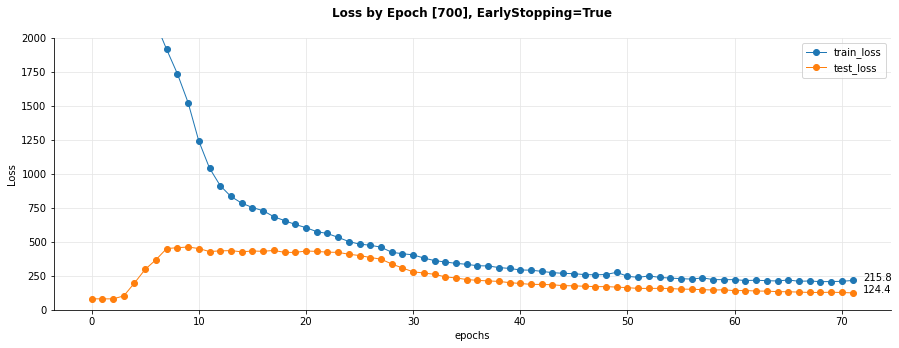

In [21]:
%%time
res = nn_manager_cut.model_fit(n_epoch=700,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

Train-Test split after swapping data [[go]](#Swapping-(the-trial-issue))

# Saving Model

In [22]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_58_171_Bidi_Stacked_3d')

In [23]:
# whenloading, pay attention to sequence of days that was used to predict value

# nn_manager_cut.model = keras.models.load_model('./saved_models/20210623_20H39M34S_192_Bidi_2d/')

### Plotting 

In [24]:
left_off_X[:3]

,High,Low,Vol,TOUTV,TRFEE,AVBLS,NTRAT,BTC_MINED_PDAY,VOL_CHANGE_PDAY,NTRAT_CH_PDAY,PRICE_UP
Date,,,,,,,,,,,
2021-06-02,38199.9,35981.1,96890.0,1.153282e+06,51.133097,1.291096,646341383.0,1212.5,-16590.0,233352.0,1
2021-06-03,39462.3,37193.6,106440.0,1.223004e+06,49.880615,1.293654,646592644.0,775.0,9550.0,251261.0,1
2021-06-04,39255.4,35659.9,127710.0,1.028877e+06,42.341365,1.290167,646848409.0,787.5,21270.0,255765.0,0


In [25]:
left_off_X.iloc[-1]

High               3.327250e+04
Low                2.890180e+04
Vol                3.096500e+05
TOUTV              1.936917e+06
TRFEE              4.779617e+01
AVBLS              1.392933e+00
NTRAT              6.507957e+08
BTC_MINED_PDAY     4.375000e+02
VOL_CHANGE_PDAY    5.278000e+04
NTRAT_CH_PDAY      2.075770e+05
PRICE_UP           1.000000e+00
Name: 2021-06-22 00:00:00, dtype: float64

In [26]:
left_off_X_unrolled, left_off_y_unrolled = nn_manager_cut.unroll_train_test_to_sequences(
    X=nn_manager_cut.scaler.transform(left_off_X), 
    y =left_off_y.values
)

left_off_X_unrolled[-1:], left_off_X_unrolled.shape[0]

>>> Method called with outer X and y. Returning X, y unrolled...


(array([[[ 4.00176354,  3.92230875, -0.00858707,  0.09468791,
          -0.09423554,  1.04507299,  1.0758465 , -0.49455677,
           0.13045648, -0.19930844, -1.        ],
         [ 3.89237849,  3.8361109 , -0.04283705,  0.06019051,
          -0.18676582,  0.56225184,  1.07662864, -0.58164852,
          -0.1752985 , -0.1510158 , -1.        ],
         [ 3.73769702,  3.57356764, -0.05939694,  0.04932606,
          -0.19039097,  0.54725831,  1.07736938, -0.47900467,
          -0.06472914, -0.21318617, -1.        ],
         [ 3.53257027,  3.53194838, -0.05295971, -0.36377011,
          -0.2675929 ,  0.6091328 ,  1.07806046, -0.5940902 ,
           0.07901102, -0.287772  , -1.        ],
         [ 3.50315141,  3.3589278 ,  0.02571206, -0.19196397,
          -0.29054013,  0.80492219,  1.07863973, -0.5940902 ,
           0.53050255, -0.45568323,  0.        ],
         [ 3.45897777,  3.11205367,  0.31904817,  0.21627495,
          -0.07995738,  1.04305026,  1.07915358, -0.5940902 ,
      

In [27]:
left_off_date_index = left_off_y.index[nn_manager_cut.training_seq_params['seq_len']:]
left_off_date_index

DatetimeIndex(['2021-06-08', '2021-06-09', '2021-06-10', '2021-06-11',
               '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15',
               '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19',
               '2021-06-20', '2021-06-21', '2021-06-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [28]:
left_off_pred = [nn_manager_cut.model_predict(seq.reshape(1,
                                                   nn_manager_cut.training_seq_params['seq_len'],
                                                   nn_manager_cut.training_seq_params['n_features']))[0][0] 
                 for seq in left_off_X_unrolled]
left_off_pred

[36654.156,
 36028.28,
 35491.133,
 35382.3,
 35982.83,
 36620.77,
 36878.0,
 38264.9,
 39464.555,
 40003.758,
 39642.49,
 38500.31,
 37468.2,
 36663.094,
 35889.277]

<AxesSubplot:xlabel='Date'>

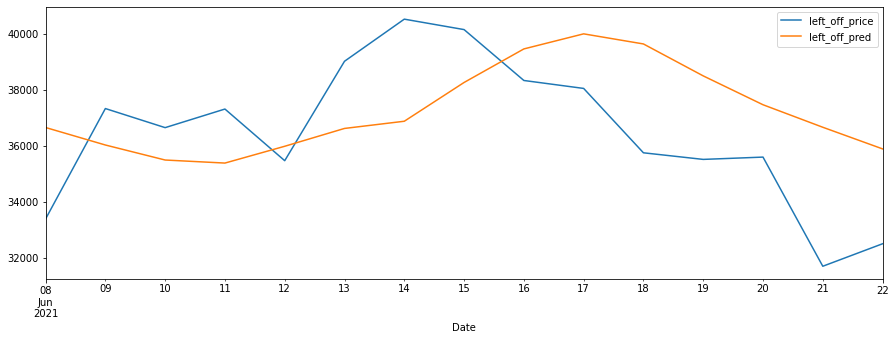

In [29]:
fig, ax = plt.subplots(1, figsize=(15,5))

pd.DataFrame(data=left_off_y_unrolled, index=left_off_date_index, columns=["left_off_price"]).plot(ax=ax)
pd.DataFrame(data=left_off_pred, index=left_off_date_index, columns=["left_off_pred"]).plot(ax=ax)

>>>Calculating predictions... done.


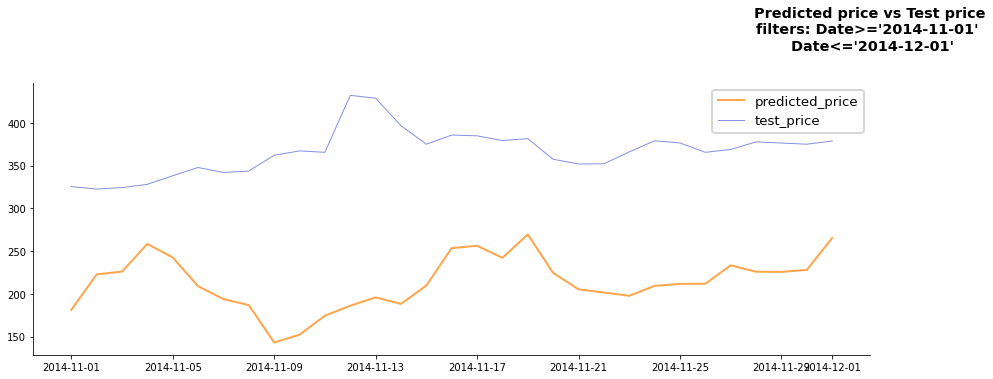

In [30]:
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.02.01'"]) 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2020.11.10'", "Date<='2021.04.10'"], legend_loc='upper left') 
# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2018.06.01'", "Date<='2018.06.15'"]) 

nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2014-11-01'", "Date<='2014-12-01'"]) 


# nn_manager_cut.plot_predicted_vs_test_price(filters=["Date>='2021.06.09'", "Date<='2021.06.17'"]) 

In [31]:
# X = nn_manager_cut.X_test['2021-06-10':'2021-06-11']
# X = nn_manager_cut.scaler.transform(X)
# nn_manager_cut.model_predict(X.reshape(1, nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0] 

In [32]:
# nn_manager_cut.y_test.loc['2021-06-12']

In [33]:
# data_for_pred = nn_manager_cut.scaler.transform(nn_manager_cut.X_test.loc['2018.06.07':'2018.06.09'])
# nn_manager_cut.model_predict(data_for_pred.reshape(1,
#                                                   nn_manager_cut.training_seq_params['seq_len'],
#                                                    nn_manager_cut.training_seq_params['n_features']))[0][0]


In [34]:
# nn_manager_cut.y_test.loc['2018.06.09']

In [35]:
# nn_manager_cut.y_test_unrolled[:3]

In [36]:
# nn_manager_cut.y_pred[:3]

In [37]:
# nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:][:3]

# Conclusion on LSTM Model: